# Inputs, transformation and cleaning

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as style
import numpy as np

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns # data visualization library  
import plotly.express as px

from scipy.stats import randint as sp_randint
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense
from keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from IPython.display import Image

# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

import xgboost as xgb


In [2]:
#Create model evaluation function
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import r2_score
    predictions = model.predict(test_features)
    R2 = np.mean(r2_score(test_labels, predictions))
    print('R2 score = %.3f' % R2)
    return r2_score

In [23]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.savefig('error.png')
    plt.show()


# Modelling

### <font color='red'>Benchmark</font>

In [4]:
slim_df = pd.read_csv("outputs/slim_df.csv")
#slim_df['X']=slim_df['Unnamed: 0']
#slim_df.drop(list(filter(lambda x: x.startswith('Unname'), slim_df)), axis = 1, inplace = True)
slim_df.set_index('X', inplace=True)
slim_df.shape

(6501, 1099)

#### Train - Test split

In [5]:
Y = slim_df['NEUI']
X = slim_df
X.drop('NEUI', axis=1, inplace=True)

In [6]:
Y.head()

X
0    0.000001
1    0.000010
2    0.000003
3    0.000021
4    0.000013
Name: NEUI, dtype: float64

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))

X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

#### fitting

In [8]:
# Create a DataFrame to store computation results obtained with different models.

Acc = pd.DataFrame(index=None, columns=['model','Train','Test'])

In [9]:
# Now, let's try to select some Regressors to check its performance.

regressors = [['SVR',SVR()],
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [8]:
for mod in regressors:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train,Y_train)
    actr = r2_score(Y_train, model.predict(X_train))
    acte = r2_score(Y_test, model.predict(X_test))
    
    Acc = Acc.append(pd.Series({'model':name, 'Train':actr,'Test':acte}),ignore_index=True )
Acc.sort_values(by='Test')

,model,Train,Test
4,MLPRegressor,-610238.345761,-3.253964e+06
0,SVR,-38.968848,-4.376039e+01
5,AdaBoostRegressor,-1.190346,-1.552534e+00
1,DecisionTreeRegressor,1.000000,9.671180e-02
2,KNeighborsRegressor,0.547541,3.654999e-01
3,RandomForestRegressor,0.930993,6.267205e-01
6,GradientBoostingRegressor,0.744202,6.479707e-01


### <font color='red'>Only significant features</font>

In [29]:
log_final_df = pd.read_csv("outputs/log_final_df.csv")
#final_df['X']=final_df['Unnamed: 0']
#final_df.drop(list(filter(lambda x: x.startswith('Unname'), final_df)), axis = 1, inplace = True)
log_final_df.set_index('X', inplace=True)
log_final_df.head()

,NEUI,WOHT2..1,PBA.15,RFGICN,DD,HTRCHLR..1,WOCOOK..1,WKHRS,WOGENR..1,PBA.6,...,WLCNS.6,DAYHARV.2,FASTFD.1,SUNGLS.1,RFCNS.6,RFGWIN,FACACT.5,WHRECOV.2,SHUNIT.1,RGSTR.1
X,,,,,,,,,,,,,,,,,,,,,
0,0.000001,1,0.0,0.000000,7747,1,1,2.833213,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000010,1,0.0,1.098612,5293,1,1,4.290459,1,0.0,...,0.0,1.0,1.0,0.0,1.0,1.098612,0.0,1.0,0.0,1.0
2,0.000003,1,1.0,0.000000,5978,1,1,3.713572,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0
3,0.000021,1,0.0,3.091042,4689,1,1,5.129899,1,0.0,...,1.0,1.0,1.0,0.0,0.0,2.564949,0.0,1.0,0.0,1.0
4,0.000013,1,0.0,0.000000,4957,1,1,4.189655,1,0.0,...,0.0,1.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0


#### Train - Test split

In [30]:
Y = log_final_df['NEUI']
X = log_final_df
X.drop('NEUI', axis=1, inplace=True)

In [31]:
Y.head()

X
0    0.000001
1    0.000010
2    0.000003
3    0.000021
4    0.000013
Name: NEUI, dtype: float64

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

#### fitting

In [33]:
# Create a DataFrame to store computation results obtained with different models.

Acc = pd.DataFrame(index=None, columns=['model','Train','Test'])

In [34]:
# Now, let's try to select some Regressors to check its performance.

regressors = [['SVR',SVR()],
              
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [35]:
for mod in regressors:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train,Y_train)
    actr = r2_score(Y_train, model.predict(X_train))
    acte = r2_score(Y_test, model.predict(X_test))
    
    Acc = Acc.append(pd.Series({'model':name, 'Train':actr,'Test':acte}),ignore_index=True )
Acc.sort_values(by='Test')

,model,Train,Test
4,MLPRegressor,-1.119494e+06,-2.029454e+06
0,SVR,-3.895845e+01,-4.374734e+01
5,AdaBoostRegressor,-1.423254e+00,-1.808228e+00
1,DecisionTreeRegressor,1.000000e+00,-2.133807e-02
2,KNeighborsRegressor,5.801778e-01,4.796103e-01
3,RandomForestRegressor,9.332375e-01,6.053106e-01
6,GradientBoostingRegressor,6.971112e-01,6.277748e-01


### <font color='red'>Top quantile significant features</font>

In [40]:
ranked_df = pd.read_csv("outputs/ranked_df.csv")
#final_df['X']=final_df['Unnamed: 0']
#final_df.drop(list(filter(lambda x: x.startswith('Unname'), final_df)), axis = 1, inplace = True)
ranked_df.set_index('X', inplace=True)
ranked_df.head()

,NEUI,DD,SQFT,WKHRS,PBA.15,NWKER,PBA.16,RFGWIN,NGUSED.1,RFGICN,...,RFGSTP,NGSRC..1,PBA.5,LABEQP.1,CLVVAV.1,RFGRES.2,RFTILT.1,RFCNS.6,PBA.91,GLSSPC.4
X,,,,,,,,,,,,,,,,,,,,,
0,0.000001,7747,7.783641,2.833213,0.0,1.098612,0.0,0.000000,0.0,0.000000,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000010,5293,11.643962,4.290459,0.0,3.970292,0.0,1.098612,1.0,1.098612,...,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.000003,5978,7.844241,3.713572,1.0,2.397895,0.0,0.693147,0.0,0.000000,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000021,4689,13.122365,5.129899,0.0,5.111988,0.0,2.564949,1.0,3.091042,...,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.000013,4957,10.308986,4.189655,0.0,2.995732,0.0,0.000000,0.0,0.000000,...,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


#### Train - Test split

In [41]:
Y = ranked_df['NEUI']
X = ranked_df
X.drop('NEUI', axis=1, inplace=True)

In [42]:
Y.head()

X
0    0.000001
1    0.000010
2    0.000003
3    0.000021
4    0.000013
Name: NEUI, dtype: float64

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

#### fitting

In [44]:
# Create a DataFrame to store computation results obtained with different models.

Acc = pd.DataFrame(index=None, columns=['model','Train','Test'])

In [45]:
# Now, let's try to select some Regressors to check its performance.

regressors = [['SVR',SVR()],
              
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [46]:
for mod in regressors:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train,Y_train)
    actr = r2_score(Y_train, model.predict(X_train))
    acte = r2_score(Y_test, model.predict(X_test))
    
    Acc = Acc.append(pd.Series({'model':name, 'Train':actr,'Test':acte}),ignore_index=True )
Acc.sort_values(by='Test')

,model,Train,Test
4,MLPRegressor,-179497.429948,-244365.279136
0,SVR,-38.958447,-43.747343
5,AdaBoostRegressor,-0.497163,-0.714953
1,DecisionTreeRegressor,1.000000,0.006252
2,KNeighborsRegressor,0.563156,0.399801
3,RandomForestRegressor,0.930821,0.602355
6,GradientBoostingRegressor,0.682365,0.610703


In [49]:
# Create random forest model 
gb_model = GradientBoostingRegressor(random_state=123)
rf_model = RandomForestRegressor(random_state=123)
kn_model = KNeighborsRegressor()

# Apply the model
gb_model.fit(X_train, Y_train)
rf_model.fit(X_train, Y_train)
kn_model.fit(X_train, Y_train)


# Predicted value
y_pred = gb_model.predict(X_test)
y_pred1 = rf_model.predict(X_test)
y_pred2 = kn_model.predict(X_test)

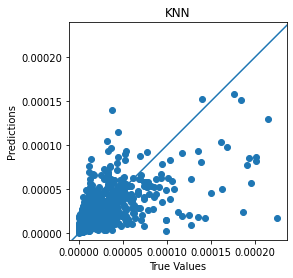

In [52]:
plot_diff(Y_test, y_pred2, title='KNN')

In [25]:
ranked_df2 = pd.read_csv("outputs/ranked_df2.csv")
#final_df['X']=final_df['Unnamed: 0']
#final_df.drop(list(filter(lambda x: x.startswith('Unname'), final_df)), axis = 1, inplace = True)
ranked_df2.set_index('X', inplace=True)
ranked_df2.head()

,NEUI,DD,SQFT,WKHRS,PBA.15,NWKER,PBA.16,RFGWIN,NGUSED.1,RFGICN,RFGCOMPN
X,,,,,,,,,,,
0,0.000001,7747,7.783641,2.833213,0.0,1.098612,0.0,0.000000,0.0,0.000000,0.000000
1,0.000010,5293,11.643962,4.290459,0.0,3.970292,0.0,1.098612,1.0,1.098612,2.397895
2,0.000003,5978,7.844241,3.713572,1.0,2.397895,0.0,0.693147,0.0,0.000000,0.000000
3,0.000021,4689,13.122365,5.129899,0.0,5.111988,0.0,2.564949,1.0,3.091042,2.197225
4,0.000013,4957,10.308986,4.189655,0.0,2.995732,0.0,0.000000,0.0,0.000000,1.098612


#### Train - Test split

In [26]:
Y = ranked_df2['NEUI']
X = ranked_df2
X.drop('NEUI', axis=1, inplace=True)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

#### fitting

In [28]:
# Create a DataFrame to store computation results obtained with different models.

Acc = pd.DataFrame(index=None, columns=['model','Train','Test'])

In [29]:
# Now, let's try to select some Regressors to check its performance.

regressors = [['SVR',SVR()],
              
              ['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['KNeighborsRegressor', KNeighborsRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [30]:
for mod in regressors:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train,Y_train)
    actr = r2_score(Y_train, model.predict(X_train))
    acte = r2_score(Y_test, model.predict(X_test))
    
    Acc = Acc.append(pd.Series({'model':name, 'Train':actr,'Test':acte}),ignore_index=True )
Acc.sort_values(by='Test')

,model,Train,Test
4,MLPRegressor,-43557.637923,-53738.617019
0,SVR,-38.958447,-43.747343
5,AdaBoostRegressor,-0.903996,-1.147087
1,DecisionTreeRegressor,1.000000,-0.054584
2,KNeighborsRegressor,0.607408,0.522007
3,RandomForestRegressor,0.921526,0.554274
6,GradientBoostingRegressor,0.639823,0.588516


In this Notebook, we calculate the best parameters for the model using “GridSearchCV”.

In [26]:
final_df = pd.read_csv("outputs/final_df.csv")
#final_df['X']=final_df['Unnamed: 0']
#final_df.drop(list(filter(lambda x: x.startswith('Unname'), final_df)), axis = 1, inplace = True)
final_df.set_index('X', inplace=True)
final_df.head()

,NEUI,WOHT2..1,PBA.15,RFGICN,DD,HTRCHLR..1,WOCOOK..1,WKHRS,WOGENR..1,PBA.6,...,WLCNS.6,DAYHARV.2,FASTFD.1,SUNGLS.1,RFCNS.6,RFGWIN,FACACT.5,WHRECOV.2,SHUNIT.1,RGSTR.1
X,,,,,,,,,,,,,,,,,,,,,
0,0.000001,1,0.0,0,7747,1,1,16,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000010,1,0.0,2,5293,1,1,72,1,0.0,...,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0
2,0.000003,1,1.0,0,5978,1,1,40,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.000021,1,0.0,21,4689,1,1,168,1,0.0,...,1.0,1.0,1.0,0.0,0.0,12.0,0.0,1.0,0.0,1.0
4,0.000013,1,0.0,0,4957,1,1,65,1,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#log_df=np.log(final_df+1)
#log_df.isnull().values.any()

In [28]:
#np.isinf(log_df).values.any()

In [29]:
# Min Max Scaler
names = log_df.columns
indexes = log_df.index
sc = MinMaxScaler((0, 1))
data_scaled = sc.fit_transform(log_df)
df = pd.DataFrame(data_scaled, columns=names, index=indexes)
df.head()

NameError: name 'log_df' is not defined

#### Train - Test split

In [30]:
Y = df['NEUI']
X = df
X.drop('NEUI', axis=1, inplace=True)

NameError: name 'df' is not defined

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 20)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train = MinMax.fit_transform(X_train)
X_test = MinMax.transform(X_test)

In [72]:
#Create model evaluation function
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import r2_score
    predictions = model.predict(test_features)
    R2 = np.mean(r2_score(test_labels, predictions))
    print('R2 score = %.3f' % R2)
    return r2_score

In [73]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

### <font color='red'>Random Forest</font>

In [74]:
# Create random forest model 
rf_model = RandomForestRegressor(random_state=123)
# Apply the model
rf_model.fit(X_train, Y_train)
# Predicted value
y_pred1 = rf_model.predict(X_test)

In [75]:
#R2 score before optimization
R2_before_rf= evaluate(rf_model, X_test, Y_test)

R2 score = 0.600


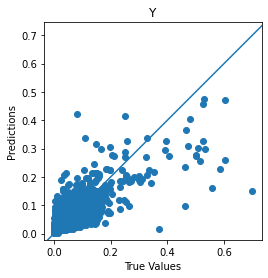

In [76]:
# Plot the loss
plot_diff(Y_test, y_pred1, title='Y')

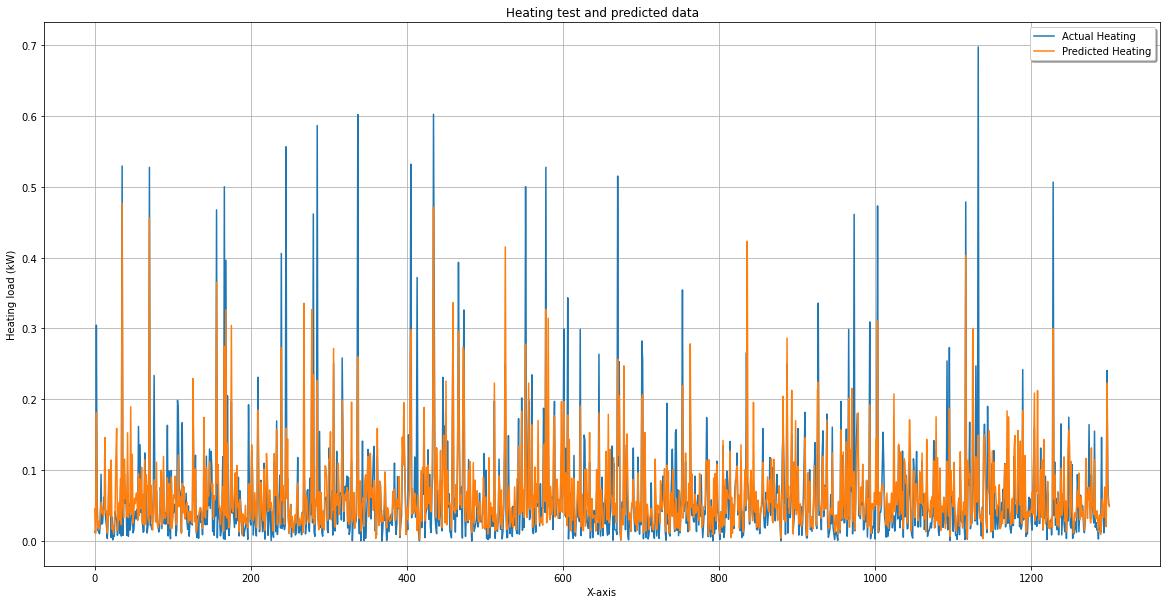

In [77]:
x_ax = range(len(Y_test))
plt.figure(figsize=(20,10))
plt.plot(x_ax, Y_test, label="Actual Heating")
plt.plot(x_ax, y_pred1, label="Predicted Heating")
plt.title("Heating test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Heating load (kW)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.show()

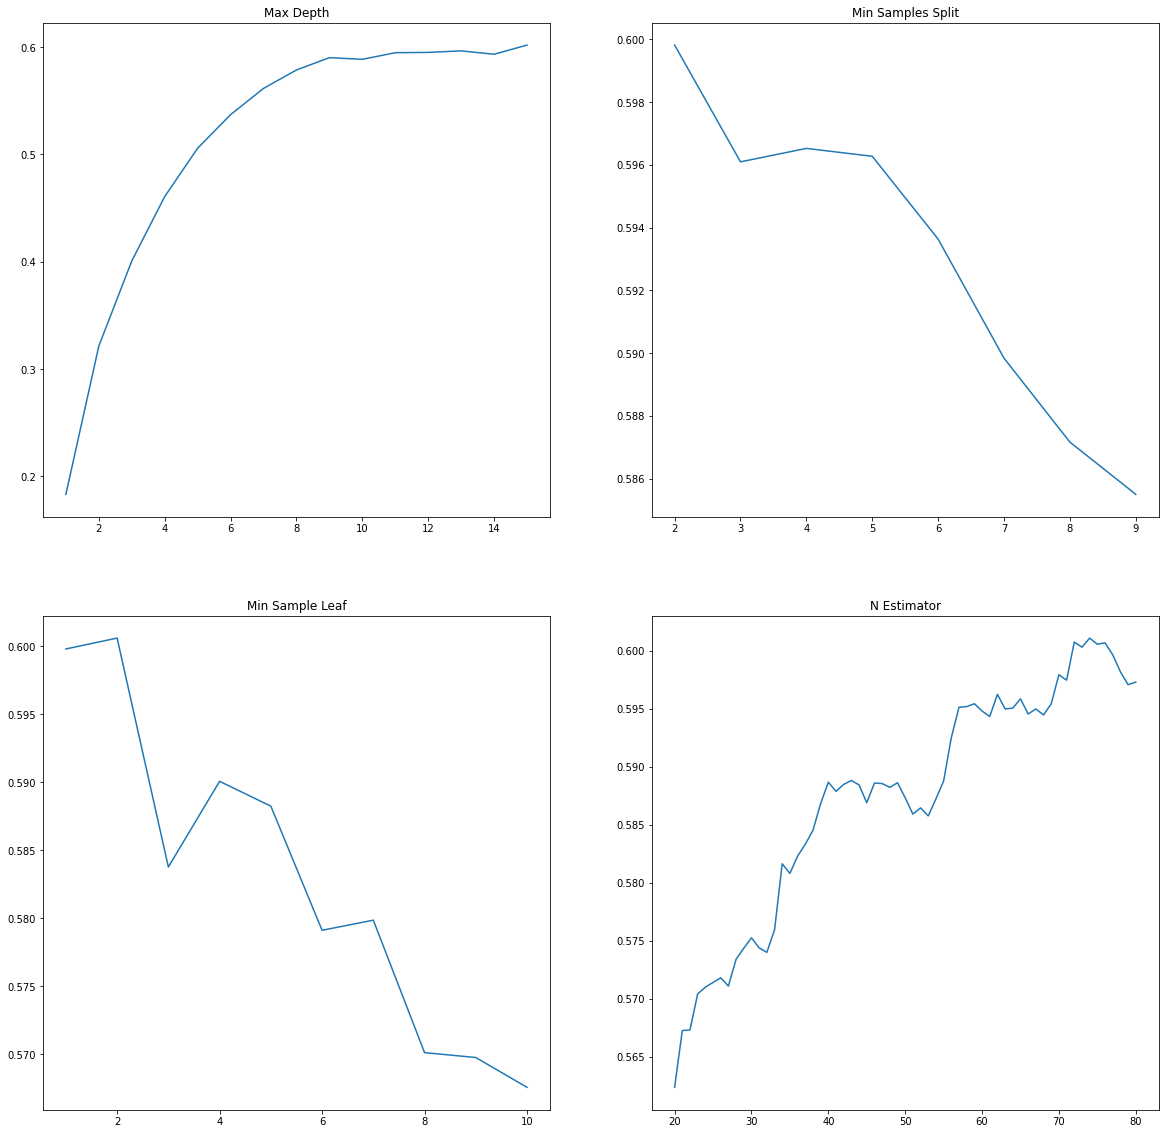

In [78]:
# Finding the best random forest optimization parameters

f, axarr = plt.subplots(2, 2, figsize = (20,20))

# Max Depth
rf_acc = []
rf_depth = range(1,16)
for i in rf_depth:
    rf = RandomForestRegressor(random_state=123, max_depth=i)
    rf.fit(X_train, Y_train)
    rf_acc.append(rf.score(X_test, Y_test))
axarr[0, 0].plot(rf_depth,rf_acc)
axarr[0, 0].set_title('Max Depth')

#Min Samples Split
rf_acc = []
rf_samples_split = range(2,10)
for i in rf_samples_split:
    rf = RandomForestRegressor(random_state=123, min_samples_split=i)
    rf.fit(X_train, Y_train)
    rf_acc.append(rf.score(X_test, Y_test))
axarr[0, 1].plot(rf_samples_split,rf_acc)
axarr[0, 1].set_title('Min Samples Split')

#Min Sample Leaf
rf_acc = []
rf_samples_leaf = range(1,11)
for i in rf_samples_leaf:
    rf = RandomForestRegressor(random_state=123, min_samples_leaf=i)
    rf.fit(X_train, Y_train)
    rf_acc.append(rf.score(X_test, Y_test))

axarr[1, 0].plot(rf_samples_leaf,rf_acc)
axarr[1, 0].set_title('Min Sample Leaf')

#N Estimator
rf_acc = []
rf_estimators = range(20,81)
for i in rf_estimators:
    rf = RandomForestRegressor(random_state=123, n_estimators=i)
    rf.fit(X_train, Y_train)
    rf_acc.append(rf.score(X_test, Y_test))

axarr[1, 1].plot(rf_estimators,rf_acc)
axarr[1, 1].set_title('N Estimator')

plt.show()

In [61]:
# Random forest optimization parameters
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : [14,15],
              'min_samples_split': [2],
              'min_samples_leaf' : [2],
              'n_estimators': [57,58,59,60]}


#Create new model using the GridSearch
rf_random = GridSearchCV(rf_model, parameters, cv=10)

#Apply the model
rf_random.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [14, 15], 'min_samples_leaf': [2],
                         'min_samples_split': [2],
                         'n_estimators': [57, 58, 59, 60]})

In [62]:
rf_random.best_params_

{'max_depth': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 58}

In [63]:
y_pred2 = rf_random.best_estimator_.predict(X_test)

In [64]:
#R2 score after optimization
best_random_rf = rf_random.best_estimator_
R2_after_rf= evaluate(best_random_rf, X_test, Y_test)

R2 score = 0.600


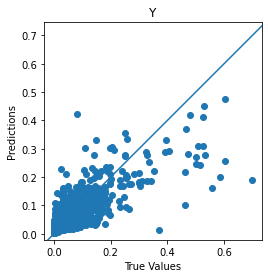

In [65]:
# Plot the loss
plot_diff(Y_test, y_pred2, title='Y')

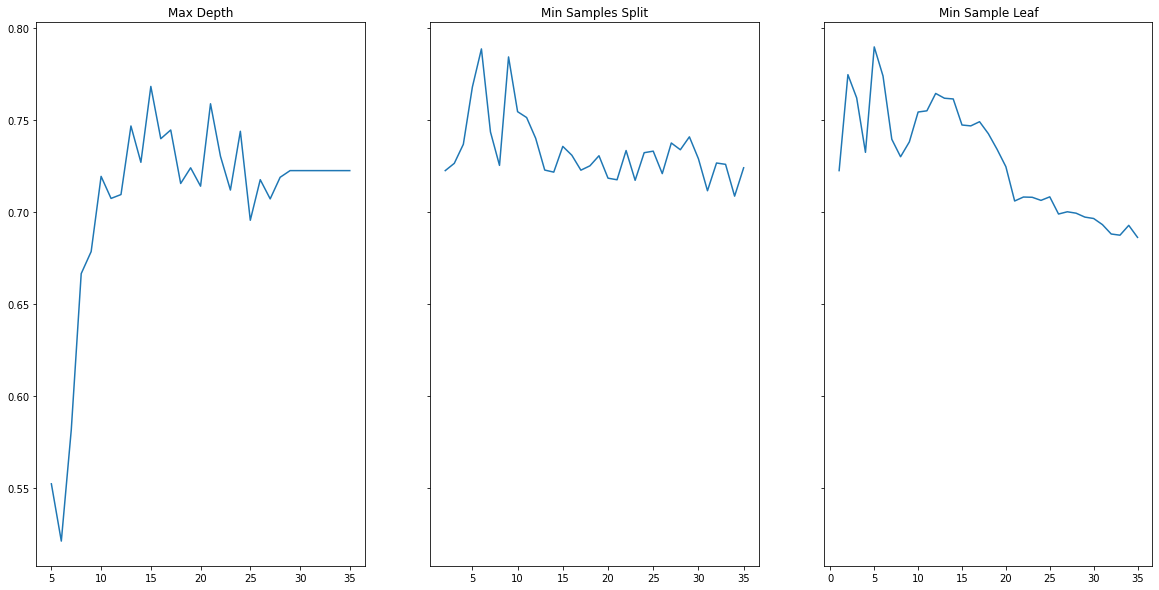

In [48]:
# Finding the best decision tree optimization parameters

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (20,10))
# Max Depth
dt_acc = []
dt_depth = range(5,36)
for i in dt_depth:
    dt = DecisionTreeRegressor(random_state=123, max_depth=i)
    dt.fit(X_train, Y_train)
    dt_acc.append(dt.score(X_test, Y_test))
ax1.plot(dt_depth,dt_acc)
ax1.set_title('Max Depth')

#Min Samples Split
dt_acc = []
dt_samples_split = range(2,36)
for i in dt_samples_split:
    dt = DecisionTreeRegressor(random_state=123, min_samples_split=i)
    dt.fit(X_train, Y_train)
    dt_acc.append(dt.score(X_test, Y_test))
ax2.plot(dt_samples_split,dt_acc)
ax2.set_title('Min Samples Split')

#Min Sample Leaf
dt_acc = []
dt_samples_leaf = range(1,36)
for i in dt_samples_leaf:
    dt = DecisionTreeRegressor(random_state=123, min_samples_leaf=i)
    dt.fit(X_train, Y_train)
    dt_acc.append(dt.score(X_test, Y_test))

ax3.plot(dt_samples_leaf,dt_acc)
ax3.set_title('Min Sample Leaf')

plt.show()

In [49]:
# Decision tree optimization parameters
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : [13,14,15,16,17],
              'min_samples_split': [5,6,7,8,9],
              'min_samples_leaf' : [2,3,4,5,6]}


#Create new model using the GridSearch
dt_random = GridSearchCV(dt_model, parameters, cv=10)

#Apply the model
dt_random.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'max_depth': [13, 14, 15, 16, 17],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 6, 7, 8, 9]})

In [50]:
#View the best parameters
dt_random.best_params_

{'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 7}

In [51]:
#R2 score after optimization
dt_best_random = dt_random.best_estimator_
R2_after_dt= evaluate(dt_best_random, X_test, Y_test)

R2 score = 0.738


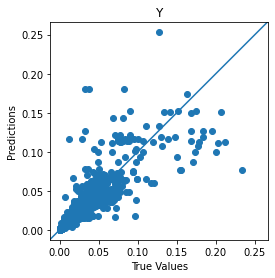

In [52]:
# Plot the loss
y_pred1 = dt_best_random.predict(X_test)
plot_diff(Y_test, y_pred1, title='Y')